In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

from scipy.signal import savgol_filter

from scipy.io import loadmat, savemat

sns.set_theme(font_scale=1.5)

In [2]:
# Photon energy [MeV], conversion factor [( erg/g(Carbon) )/ ( photon/cm^2 )]
# From Flux to Dose Rate Conversion Factors for Gamma Ray Exposure, J.H. Smith, 1963
convFactor = np.array([[9.6790e-3, 6.8229e-8], [1.0879e-2, 5.4124e-8],
                       [1.2230e-2, 4.2178e-8], [1.3503e-2, 3.4365e-8],
                       [1.5179e-2, 2.7019e-8], [1.7688e-2, 1.9607e-8],
                       [2.0430e-2, 1.4356e-8], [2.3173e-2, 1.1088e-8],
                       [2.8757e-2, 7.1666e-9], [3.5677e-2, 4.7996e-9],
                       [4.3459e-2, 3.4824e-9], [5.2414e-2, 2.9130e-9],
                       [6.0409e-2, 2.8097e-9], [8.2998e-2, 3.2641e-9],
                       [1.0522e-1, 4.1829e-9], [1.2876e-1, 5.2665e-9],
                       [1.6458e-1, 7.3109e-9], [2.2372e-1, 1.0702e-8],
                       [2.9625e-1, 1.4987e-8], [4.1006e-1, 2.0984e-8],
                       [5.5293e-1, 2.7858e-8], [7.5880e-1, 3.7644e-8],
                       [1.1176e+0, 5.1765e-8], [1.8301e+0, 7.4390e-8],
                       [3.2731e+0, 1.1172e-7], [4.6967e+0, 1.4438e-7],
                       [7.2308e+0, 1.9851e-7], [9.8416e+0, 2.4762e-7]])

11    4.160000e-10
Name: AP, dtype: float64


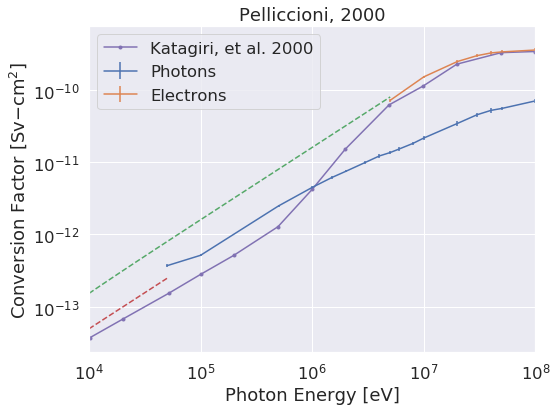

In [3]:
from io import StringIO

s = """
0.00005 3.68E-13 2.2
0.0001 5.13E-13 1.3
0.0005 2.48E-12 1.4
0.001 4.47E-12 2.4 
0.0015 6.13E-12 2.0
0.002 7.47E-12 1.7 
0.003 9.94E-12 2.1 
0.004 1.22E-11 3.2 
0.005 1.36E-11 2.0 
0.006 1.52E-11 2.8 
0.008 1.82E-11 3.0 
0.01 2.16E-11 2.8
0.02 3.44E-11 3.5
0.03 4.54E-11 3.5
0.04 5.22E-11 3.3
0.05 5.55E-11 2.4
0.1 7.06E-11 3.7
0.2 8.16E-11 3.0
0.5 9.37E-11 3.6
1.0 1.03E-10 3.4
2.0 1.05E-10 3.3
5.0 1.07E-10 3.8
10.0 1.10E-10 3.0
50.0 1.17E-10 3.1
100.0 1.19E-10 2.4
"""

s2 = """
0.005 7.19E-11 3.0
0.01 1.52E-10 1.7
0.02 2.48E-10 1.8 
0.03 2.99E-10 1.9 
0.04 3.26E-10 2.6 
0.05 3.37E-10 2.6 
0.1 3.58E-10 3.3
0.2 3.66E-10 3.2
0.5 3.89E-10 2.8
1.0 3.99E-10 3.6
2.0 4.07E-10 3.5
5.0 4.16E-10 3.5
10.0 4.30E-10 2.7 
50.0 4.57E-10 2.1 
100.0 4.57E-10 1.7 
"""

s3 = np.array([[1.02341e+4, 3.71785e-14],
[2.00220e+4, 6.68242e-14],
[5.17092e+4, 1.52414e-13],
[1.00000e+5, 2.79012e-13],
[1.97917e+5, 5.10767e-13],
[4.93705e+5, 1.27674e-12],
[1.00000e+6, 4.20090e-12],
[1.97917e+6, 1.51486e-11],
[4.88025e+6, 6.21017e-11],
[9.88496e+6, 1.13685e-10],
[1.97917e+7, 2.28082e-10],
[4.93705e+7, 3.29034e-10],
[9.88496e+7, 3.41316e-10]]);


# Energy in GeV, AP in Sv cm^2, error in percent
photonConv = pd.read_table(StringIO(s),
                           names=['E', 'AP', 'AP_err'],
                           delimiter=' ')

# Energy in GeV, AP in Sv cm^2, error in percent
electronConv = pd.read_table(StringIO(s2),
                             names=['E', 'AP', 'AP_err'],
                             delimiter=' ')

print(electronConv.AP[electronConv.E == 5])

plt.figure(figsize=(8, 6))
plt.errorbar(photonConv.E * 1e3 * 1e6,
             photonConv.AP,
             yerr=photonConv.AP * 2 * photonConv.AP_err / 100,
             label='Photons')
plt.errorbar(electronConv.E * 1e3 * 1e6,
             electronConv.AP,
             yerr=electronConv.AP * 2 * electronConv.AP_err / 100,
             label='Electrons')


m = (electronConv.AP[1] - electronConv.AP[0]) / \
    (electronConv.E[1] - electronConv.E[0])
b = electronConv.AP[0] - m * electronConv.E[0]

x = np.logspace(-2, np.log10(electronConv.E[0] * 1e3), 100)

plt.plot(x * 1e6, (m * x + b) * 1e-3, '--')

m_ph = (photonConv.AP[2] - photonConv.AP[1]) / \
    (photonConv.E[2] - photonConv.E[1])
b_ph = photonConv.AP[1] - m_ph * photonConv.E[1]

x_ph = np.logspace(-2, np.log10(photonConv.E[0] * 1e3), 10)

plt.plot(x_ph * 1e6, (m_ph * x_ph + b_ph) * 1e-3, '--')


plt.plot(s3[:,0], s3[:,1], '.-', label='Katagiri, et al. 2000')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Photon Energy [eV]')
plt.ylabel('Conversion Factor [Sv$-$cm$^2$]')
plt.title('Pelliccioni, 2000')
plt.legend();
plt.xlim([1e4, 1e8]);

In [4]:
N = 1e5

Earray_resample = np.logspace(-2, 1, 100)  # MeV

el_conv = np.interp(Earray_resample,
                    np.hstack([x, electronConv.E]) * 1e3,
                    np.hstack([(m * x + b) * 1e-3, electronConv.AP]))
el_conv = np.interp(Earray_resample, 
                   s3[:,0] * 1e3,
                   s3[:,1])

ph_conv = np.interp(Earray_resample,
                    np.hstack([x_ph, photonConv.E]) * 1e3,
                    np.hstack([(m_ph * x_ph + b_ph) * 1e-3, photonConv.AP]))

el_convCurve = [Earray_resample, el_conv]
ph_convCurve = [Earray_resample, ph_conv]

In [5]:
def plot_spectra(ionResults, EResults, ionVar, Evar):

    h = np.linspace(0, 999, 1000)
    Earray = np.round(np.logspace(np.log10(0.250), np.log10(1000), 100), 2)

    def KrauseIonization(altitude):
        '''
        altitude in km
        returns ionization in keV
        '''
        r = (-0.03 * altitude + 39.78) / 1e3
        r[altitude > 240] = (-0.03 * 240 + 39.78) / 1e3
        r[altitude < 45] = (-0.03 * 45 + 39.78) / 1e3

        return r

    plt.figure(figsize=(14, 8))
    plt.subplot(1, 2, 1)
    plt.grid(True, which='both')
    plt.plot(ionResults / KrauseIonization(h), h, label='$\mu$')
    plt.fill_betweenx(h, (ionResults - 1.96 * ionVar) / KrauseIonization(h),
                      (ionResults + 1.96 * ionVar) / KrauseIonization(h),
                      alpha=0.5,
                      label='95% CL')

    plt.xscale('log')
    plt.xlabel('Ionization Rate [cm$^{-3}$ s$^{-1}$]')
    plt.ylabel('Altitude [km]')
    plt.ylim([0, 240])
    plt.legend()

    X, Y = np.meshgrid(Earray, h)

    plt.subplot(1, 2, 2)
    plt.grid(True, which='both')
    plt.contourf(X, Y, np.log10(EResults))
    plt.colorbar(label='log$_{10}$ Number of Occurances')

    plt.xscale('log')
    plt.xlabel('Energy [keV]')
    plt.ylabel('Altitude [km]')
    plt.ylim([0, 240])


def convert2radiationDose(photon_energySpectra, photon_conversionCurve,
                          electron_energySpectra, electron_conversionCurve):

    resultsArr = np.zeros([1000])
    for i in range(0, 1000):
        resultsArr[i] = np.sum(photon_energySpectra[i, :] * photon_conversionCurve[1]) + \
            np.sum(electron_energySpectra[i, :] * electron_conversionCurve[1])

    return resultsArr / 100 # Conversion to Sv

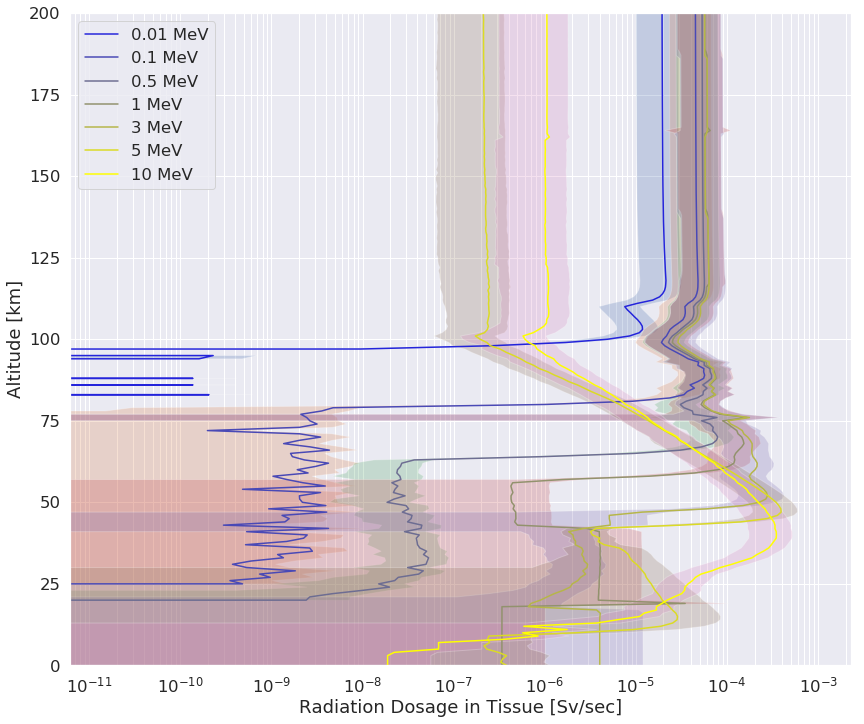

In [13]:
from scipy.signal import savgol_filter


def plotResults(name, label, C):

    if label == "5 MeV":
        factor = 1e0 * 1e6
    elif label == "10 MeV":
        factor = 1e1 * 1e6
    else:
        factor = 1 * 1e6

    path = "G4_data/"

    d1 = loadmat(path + name)

    R = factor * savgol_filter(
        convert2radiationDose(d1['photonEnergyDep'], ph_convCurve,
                              d1['electronEnergyDep'], el_convCurve), 1, 0) / 1.0132

    R_stddev = factor * convert2radiationDose(
        d1['photonEnergyDep_stddev'], ph_convCurve,
        d1['electronEnergyDep_stddev'], el_convCurve)

    plt.semilogx(R,
                 np.linspace(0, 999, 1000),
                 label=label,
                 color=[C / 7, C / 7, 1 - C / 7])
    plt.fill_betweenx(np.linspace(0, 999, 1000),
                      (R - 1.96 * R_stddev),
                      (R + 1.96 * R_stddev),
                      alpha=0.25)
    plt.xscale('log')
    plt.xlabel('Radiation Dosage in Tissue [Sv/sec]')
    plt.ylabel('Altitude [km]')
    plt.ylim([0, 200])
    plt.legend()


def plotResultsNoMod(name, label, C):

    path = "G4_data/"

    d1 = loadmat(path + name)

    factor = 1e6;
    factor = 1;

    R = factor * savgol_filter(
        convert2radiationDose(d1['photonEnergyDep'], ph_convCurve,
                              d1['electronEnergyDep'], el_convCurve), 5, 1) / 1.0132

    R_stddev = factor * convert2radiationDose(
        d1['photonEnergyDep_stddev'], ph_convCurve,
        d1['electronEnergyDep_stddev'], el_convCurve)

    plt.semilogx( R,
                 np.linspace(0, 999, 1000),
                 label=label,
                 color=[C / 7, C / 7, 1 - C / 7])
    
    #plt.fill_betweenx(np.linspace(0, 999, 1000),
    #                   (R - 1.96 * R_stddev),
    #                   (R + 1.96 * R_stddev),
    #                  alpha=0.25)
    plt.xscale('log')
    plt.xlabel('Radiation Dosage in Tissue [Sv sec$^{-1}$]')
    plt.ylabel('Altitude [km]')
    plt.ylim([0, 200])
    plt.legend()
    
    
def plotResultsIoniz(name, label):

    path = "G4_data/"

    d1 = loadmat(path + name)

    h = np.linspace(0, 999, 1000);
    Earray = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)
    
    Ewidth = np.diff(Earray);
    Ewidth = np.hstack([Ewidth, Ewidth[-1]]).flatten();

    X,Y = np.meshgrid(Earray, h);

    spectra = d1['electronEnergyDep'] / Ewidth[np.newaxis, :];
    
    plt.contourf(X,Y, np.log10(d1['electronEnergyDep']), cmap='plasma', alpha=0.5);
    plt.colorbar(label='log$_{10}$ Electron Flux [cm$^{-2}$ sec$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
    #(X,Y, d1['photonEnergyDep'], cmap='plasma', alpha=0.25)

    plt.title(label);
    plt.xscale('log')
    plt.xlabel('Energy [keV]')
    plt.ylabel('Altitude [km]')
    plt.ylim([0, 200])


plt.figure(figsize=(14, 12))

plotResults("G4_sinePAD_mono10keV.mat", "0.01 MeV", 1)
plotResults("G4_sinePAD_mono100keV.mat", "0.1 MeV", 2)
plotResults("G4_sinePAD_mono500keV.mat", "0.5 MeV", 3)
plotResults("G4_sinePAD_mono1000keV.mat", "1 MeV", 4)
plotResults("G4_sinePAD_mono3000keV.mat", "3 MeV", 5)
plotResults("G4_sinePAD_mono5000keV.mat", "5 MeV", 6)
plotResults("G4_sinePAD_mono10MeV.mat", "10 MeV", 7)

#plt.xlim([1e-7 * 1e6, 5e-5 * 1e6])
plt.grid(True, which='both')

dict_keys(['__header__', '__version__', '__globals__', 'alt', 'me', 'rad', 'radbrem', 'radpri', 'radsec'])


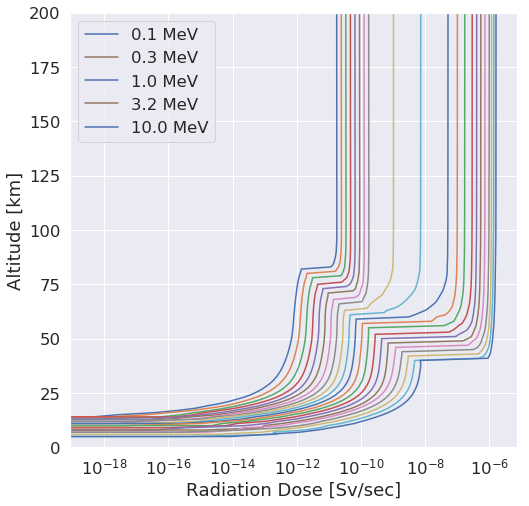

In [7]:
epmc = loadmat("lookup_radiation.mat")

print(epmc.keys())

plt.figure(figsize=(8, 8))
for i in range(0, 21):
    if i % 5 == 0:
        label = "%.1f MeV" % (epmc['me'][0, i] / 1e6)
    else:
        label = None
    plt.semilogx(epmc['rad'][i, :] / 3600, epmc['alt'].flatten(), label=label)
plt.xlabel('Radiation Dose [Sv/sec]')
plt.ylabel('Altitude [km]')
plt.ylim([0, 200])
plt.legend();

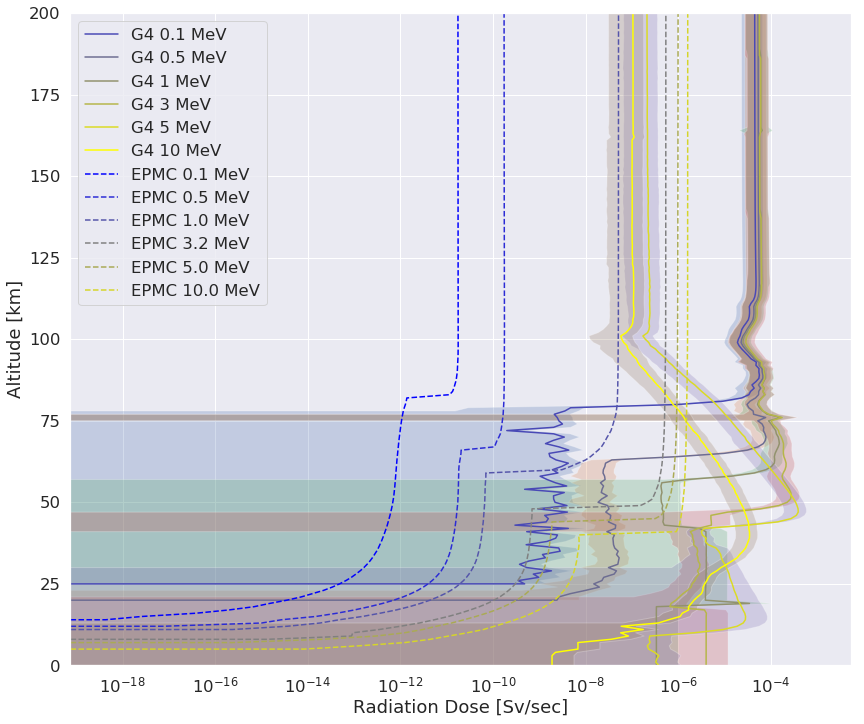

In [14]:
plt.figure(figsize=(14, 12))

#plotResults("G4_sinePAD_mono10keV.mat", "0.01 MeV", 1);
plotResults("G4_sinePAD_mono100keV.mat", "G4 0.1 MeV", 2)
plotResults("G4_sinePAD_mono500keV.mat", "G4 0.5 MeV", 3)
plotResults("G4_sinePAD_mono1000keV.mat", "G4 1 MeV", 4)
plotResults("G4_sinePAD_mono3000keV.mat", "G4 3 MeV", 5)
plotResults("G4_sinePAD_mono5000keV.mat", "G4 5 MeV", 6)
plotResults("G4_sinePAD_mono10MeV.mat", "G4 10 MeV", 7)

for ind, i in enumerate([0, 7, 10, 15, 17, 20]):
    plt.semilogx(epmc['rad'][i, :] / 3600,
                 epmc['alt'].flatten(),
                 '--',
                 label="EPMC %.1f MeV" % (epmc['me'][0, i] / 1e6),
                 color=[ind / 6, ind / 6, 1 - ind / 6])
plt.xlabel('Radiation Dose [Sv/sec]')
plt.ylabel('Altitude [km]')
plt.ylim([0, 200])
plt.legend();

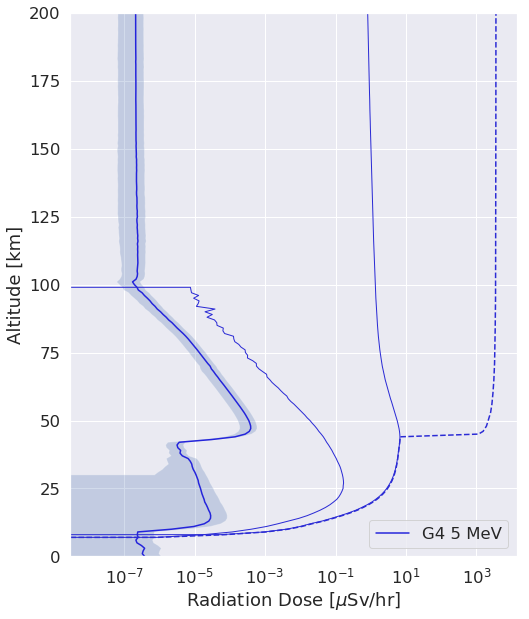

In [15]:
plt.figure(figsize=(8,10))
plotResults("G4_sinePAD_mono5000keV.mat", "G4 5 MeV",  1);

ind = 1;
plt.semilogx(1e6*epmc['rad'][17,:], epmc['alt'].flatten(), '--', 
                 label="EPMC %.1f MeV" % (epmc['me'][0,i]/1e6), color=[ind/6,ind/6,1-ind/6]);
plt.xlabel('Radiation Dose [$\mu$Sv/hr]');
plt.ylabel('Altitude [km]');

plt.semilogx(1e6*epmc['radbrem'][17,:], epmc['alt'].flatten(), '-', linewidth=1, 
                 label="EPMC %.1f MeV" % (epmc['me'][0,i]/1e6), color=[ind/6,ind/6,1-ind/6]);
plt.semilogx(1e6*epmc['radsec'][17,:], epmc['alt'].flatten(), '-', linewidth=1, 
                 label="EPMC %.1f MeV" % (epmc['me'][0,i]/1e6), color=[ind/6,ind/6,1-ind/6]);

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log10


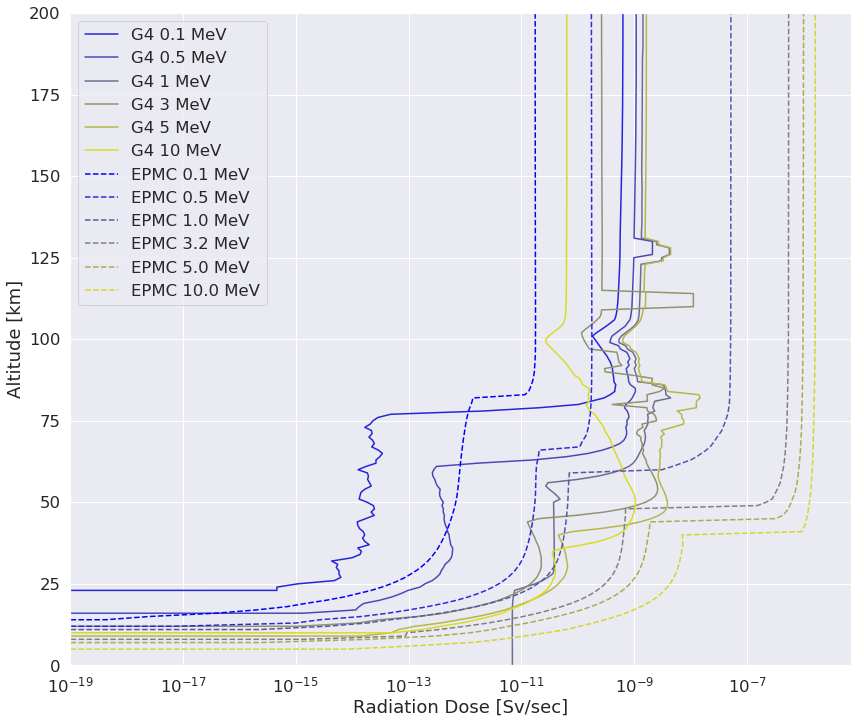

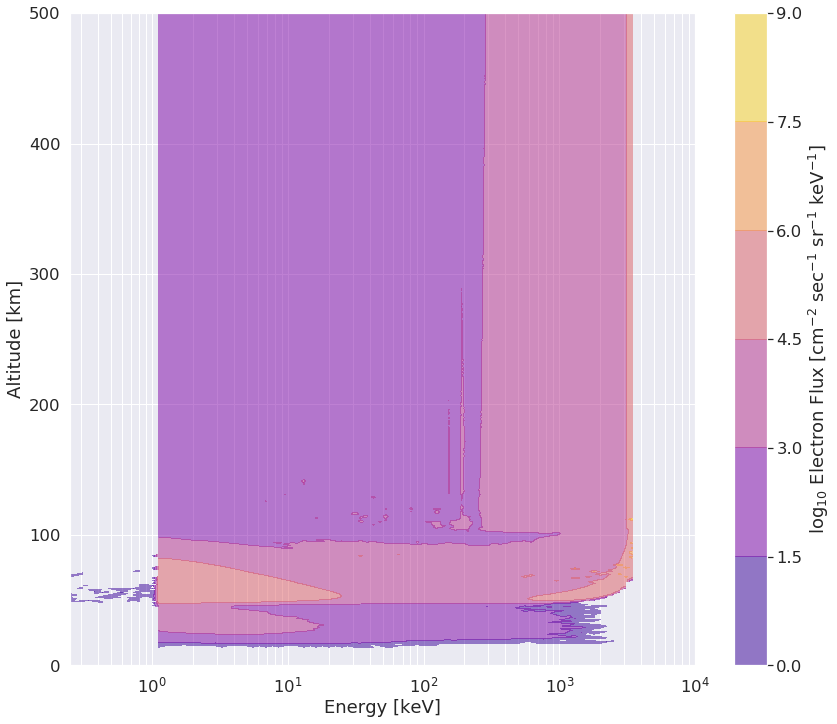

In [16]:
plt.figure(figsize=(14, 12))

plotResultsNoMod("G4_isoPAD_mono100keV.mat", "G4 0.1 MeV", 1)
plotResultsNoMod("G4_isoPAD_mono500keV.mat", "G4 0.5 MeV", 2)
plotResultsNoMod("G4_isoPAD_mono1000keV.mat", "G4 1 MeV", 3)
plotResultsNoMod("G4_isoPAD_mono3000keV.mat", "G4 3 MeV", 4)
plotResultsNoMod("G4_isoPAD_mono5000keV.mat", "G4 5 MeV", 5)
plotResultsNoMod("G4_isoPAD_mono10000keV.mat", "G4 10 MeV", 6)

#plt.xlim([1e-7 * 1e6, 5e-5 * 1e6]);
plt.grid(True, which='both')

for ind, i in enumerate([0, 7, 10, 15, 17, 20]):
    
    plt.semilogx(epmc['rad'][i, :] / 3600,
                 epmc['alt'].flatten(),
                 '--',
                 label="EPMC %.1f MeV" % (epmc['me'][0, i] / 1e6),
                 color=[ind / 6, ind / 6, 1 - ind / 6])
                 
plt.xlabel('Radiation Dose [Sv/sec]')
plt.ylabel('Altitude [km]')
plt.ylim([0, 200])
plt.legend();

plt.figure(figsize=(14, 12));
plotResultsIoniz("G4_isoPAD_mono3000keV.mat", "");
plt.ylim([0, 500]);
plt.grid(True, which='both')

In [10]:
E = [100, 500, 1000, 3000, 5000, 10000]
f = 1e4 / 1.0132; # cm^-2 sec^-1

for item in E:
    print("E0 = %.1f MeV , %.1e erg/cm^2/sec" % (item/1e3, 1.60218e-9 * f * item));

E0 = 0.1 MeV , 1.6e-03 erg/cm^2/sec
E0 = 0.5 MeV , 7.9e-03 erg/cm^2/sec
E0 = 1.0 MeV , 1.6e-02 erg/cm^2/sec
E0 = 3.0 MeV , 4.7e-02 erg/cm^2/sec
E0 = 5.0 MeV , 7.9e-02 erg/cm^2/sec
E0 = 10.0 MeV , 1.6e-01 erg/cm^2/sec
